The Transcations PGM shown here is derived from the cancer (http://www.bnlearn.com/bnrepository/#cancer) bayesian network architecture using pgmpy and do some simple queries on the network.

In pgmpy, the general flow of defining a network is to first define the network and then add the parameters to it.
Then we will begin querying the network for results.

Note: In this example we are using discrete values for random variables Time,Amount,Suspicious,Fraud and User Error {0,1} for demonstration purposes.

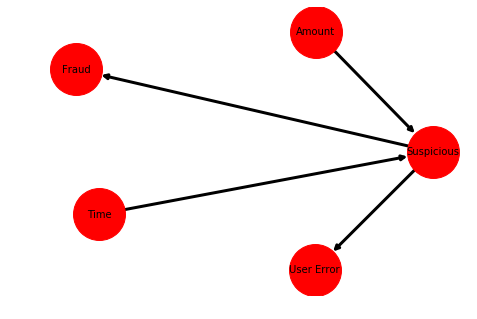

In [19]:
# Import Required Packages
from pgmpy.models import BayesianModel
import networkx as nx
import pylab as plt


#Initialise Bayesian Transactions Model
transact_model = BayesianModel([('Time', 'Suspicious'), 
                              ('Amount', 'Suspicious'),
                              ('Suspicious', 'Fraud'),
                              ('Suspicious', 'User Error')]) 


# Display PGM using NetworkX package
nx.draw(transact_model,width = 3,node_size = 2700, font_size = 10, with_labels=True)
plt.show()

In [47]:
# Creating the CPD associated with the network
from pgmpy.factors.discrete import TabularCPD

cpd_time = TabularCPD(variable='Time', variable_card=2,
                      values=[[0.9], [0.1]])

cpd_amount = TabularCPD(variable='Amount', variable_card=2,
                       values=[[0.3], [0.7]])

cpd_suspicious = TabularCPD(variable='Suspicious', variable_card=2,
                        values=[[0.03, 0.05, 0.001, 0.02],
                                [0.97, 0.95, 0.999, 0.98]],
                        evidence=['Amount', 'Time'],
                        evidence_card=[2, 2])

cpd_fraud = TabularCPD(variable='Fraud', variable_card=2,
                      values=[[0.9, 0.2], [0.1, 0.8]],
                      evidence=['Suspicious'], evidence_card=[2])

cpd_user_error = TabularCPD(variable='User Error', variable_card=2,
                      values=[[0.65, 0.3], [0.35, 0.7]],
                      evidence=['Suspicious'], evidence_card=[2])

In [48]:
print(cpd_amount)

+-----------+-----+
| Amount(0) | 0.3 |
+-----------+-----+
| Amount(1) | 0.7 |
+-----------+-----+


In [49]:
print(cpd_fraud)

+------------+---------------+---------------+
| Suspicious | Suspicious(0) | Suspicious(1) |
+------------+---------------+---------------+
| Fraud(0)   | 0.9           | 0.2           |
+------------+---------------+---------------+
| Fraud(1)   | 0.1           | 0.8           |
+------------+---------------+---------------+


In [50]:
# Associating the cpds with the Bayesian Network
transact_model.add_cpds(cpd_time, cpd_amount, cpd_suspicious, cpd_fraud, cpd_user_error)

In [51]:
# Checking if the transactions cpds are valid for the model.
transact_model.check_model()

True

In [53]:
transact_model.active_trail_nodes('Amount')

{'Amount': {'Amount', 'Fraud', 'Suspicious', 'User Error'}}

In [52]:
# Doing some simple queries on the network
transact_model.is_active_trail('Amount', 'Time')

False

In [31]:
transact_model.is_active_trail('Amount', 'Time', observed=['Suspicious'])

True

In [54]:
transact_model._get_ancestors_of('Fraud')

{'Amount', 'Fraud', 'Suspicious', 'Time'}

In [33]:
transact_model.local_independencies('Fraud')

(Fraud _|_ User Error, Amount, Time | Suspicious)

In [36]:
transact_model.get_independencies()

(Time _|_ Amount)
(Time _|_ User Error, Fraud | Suspicious)
(Time _|_ Fraud | Suspicious, User Error)
(Time _|_ User Error | Suspicious, Fraud)
(Time _|_ User Error, Fraud | Suspicious, Amount)
(Time _|_ Fraud | Suspicious, User Error, Amount)
(Time _|_ User Error | Suspicious, Fraud, Amount)
(Amount _|_ Time)
(Amount _|_ User Error, Fraud | Suspicious)
(Amount _|_ Fraud | Suspicious, User Error)
(Amount _|_ User Error | Suspicious, Fraud)
(Amount _|_ User Error, Fraud | Suspicious, Time)
(Amount _|_ Fraud | Suspicious, User Error, Time)
(Amount _|_ User Error | Suspicious, Fraud, Time)
(Fraud _|_ User Error, Amount, Time | Suspicious)
(Fraud _|_ Amount, Time | Suspicious, User Error)
(Fraud _|_ User Error, Time | Suspicious, Amount)
(Fraud _|_ User Error, Amount | Suspicious, Time)
(Fraud _|_ Time | Suspicious, User Error, Amount)
(Fraud _|_ Amount | Suspicious, User Error, Time)
(Fraud _|_ User Error | Suspicious, Amount, Time)
(User Error _|_ Fraud, Amount, Time | Suspicious)
(User 

In [59]:
# Convert Bayesian Model to Junction Tree/ Clique Tree
jt = transact_model.to_junction_tree()